In [1]:
import logging
import warnings
import datetime
import sys
import pickle
from glob import glob
import time
from itertools import product

import pandas as pd
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from shapely.geometry import box
from statsmodels import api as sm
import pylab

warnings.filterwarnings("ignore")
logging.basicConfig(format='%(asctime)s [%(levelname).7s] %(message)s', datefmt='%d/%m %H:%M:%S', level=logging.INFO)

In [2]:
regions = pd.read_csv('../data/regions.csv', sep=';', index_col=0)

region_mapping = {}
for i, row in regions.iterrows():
    region_mapping[(row['west'], row['south'])] = i
    
bins_lon = sorted(list(set(regions['west'].unique().tolist() + regions['east'].unique().tolist())))
bins_lat = sorted(list(set(regions['south'].unique().tolist() + regions['north'].unique().tolist())))

# с 2015 года появлется ещё 1 столбец
cols_18 = ['vendor', 'pickup_time', 'dropoff_time', 'passenger_count', 'trip_distance',
           'start_lon', 'start_lat', 'rate', 'store_and_forward', 'end_lon', 'end_lat',
           'payment_type', 'fare_amount', 'surcharge', 'tax', 'tip_amount', 'tolls_amount', 'total_amount']

cols_19 = ['vendor', 'pickup_time', 'dropoff_time', 'passenger_count', 'trip_distance',
           'start_lon', 'start_lat', 'rate', 'store_and_forward', 'end_lon', 'end_lat',
           'payment_type', 'fare_amount', 'surcharge', 'tax', 'tip_amount', 'tolls_amount', 
           'improvement_surcharge', 'total_amount']

def read_data(file_path, nrows=None):
    file = file_path.replace(' ', '\ ').split('/')[-1]
    y = int(file[file.find('20'):file.find('20') + 4])
    if y < 2015:
        columns = cols_18
    else:
        columns = cols_19
    logging.info('Reading {}'.format(file))
    data = pd.read_csv(file_path, names=columns, skiprows=1, nrows=nrows,
                       parse_dates=['pickup_time', 'dropoff_time'], dayfirst=True)
    logging.info('{} shape = {}'.format(file, data.shape))
    return data

def map_region(data):
    data['start_lon_bin'] = pd.cut(data['start_lon'], bins=bins_lon,
                                   precision=25, include_lowest=True)
    data['start_lat_bin'] = pd.cut(data['start_lat'], bins=bins_lat,
                                   precision=25, include_lowest=True)
    region_id = []
    for lon, lat in zip(data['start_lon_bin'], data['start_lat_bin']):
        region_id.append(region_mapping[(lon.left, lat.left)])
    data['region_id'] = region_id  
    return data

def clear_data(data):
    res = data[(data['trip_distance'] > 0) &
               (data['passenger_count'] > 0) &
               (data['dropoff_time'] > data['pickup_time']) &
               (data['start_lon'] >= -74.25559) &
               (data['start_lon'] <= -73.70001) &
               (data['start_lat'] >= 40.49612) &
               (data['start_lat'] <= 40.91553)]
    return res

def aggregate_data(data, region_id=None):
    data['hour'] = data['pickup_time'].dt.hour
    data['date'] = data['pickup_time'].dt.date
    data_agg = data.groupby(['region_id', 'date', 'hour']).size().rename('count')
    min_date = data['date'].min()
    max_date = data['date'].max()
    
    data_range = pd.DataFrame(pd.date_range(min_date, max_date + datetime.timedelta(days=1), freq='1H')[:-1],
                              columns=['datetime'])
    regions_df = pd.DataFrame(list(range(1, 2501)), columns=['region_id'])
    if region_id:
        regions_df = regions_df[regions_df['region_id'] == region_id]
    data_range['tmp'] = 1
    regions_df['tmp'] = 1

    timeseries = pd.merge(data_range, regions_df, how='outer').drop('tmp', axis=1)
    timeseries['date'] = timeseries['datetime'].dt.date
    timeseries['hour'] = timeseries['datetime'].dt.hour
    timeseries = timeseries.set_index(['region_id', 'date', 'hour'])
    
    data_full = timeseries.join(data_agg) \
                          .fillna(0) \
                          .sort_values(by='count', ascending=False) \
                          .reset_index()
    
    return data_full

def read_and_process(file_path, nrows=None):
    logging.info('Processing {}'.format(file_path))
    data = read_data(file_path, nrows=nrows)
    logging.info('Clearing {}'.format(file_path))
    data = clear_data(data)
    logging.info('Mapping regions {}'.format(file_path))
    data = map_region(data)
    logging.info('Aggregating {}'.format(file_path))
    data = aggregate_data(data)
    logging.info('Finished {}'.format(file_path))
    return data

def get_one_region(file_path, region_id):
    logging.info('Processing {}'.format(file_path))
    data = read_data(file_path, nrows=nrows)

    region_info = regions[regions.index == region_id].iloc[0].values
    data = data[(data['start_lon'] >= region_info[0]) &
                (data['start_lon'] < region_info[1]) &
                (data['start_lat'] >= region_info[2]) &
                (data['start_lat'] < region_info[3])]
    logging.info('Clearing {}'.format(file_path))
    data = clear_data(data)
    data['region_id'] = region_id
    logging.info('Aggregating {}'.format(file_path))
    data = aggregate_data(data, region_id=region_id)
    logging.info('Finished {}'.format(file_path))
    return data

Перенос данных из csv на HDD в pickle на SSD

In [19]:
for file in tqdm(sorted(glob('/Volumes/Untitled 1/ml_specialization/data/*.csv'))[:-1]):
    data = read_and_process(file, nrows=None)
    with open('../data_pickle/' + file.split('/')[-1][:-4] + '.pickle', 'wb') as f:
        pickle.dump(data, f)

22/06 17:10:30 [INFO] Processing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2009-01.csv
22/06 17:10:30 [INFO] Reading yellow_tripdata_2009-01.csv
22/06 17:11:46 [INFO] yellow_tripdata_2009-01.csv shape = (14092413, 18)
22/06 17:11:46 [INFO] Clearing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2009-01.csv
22/06 17:11:52 [INFO] Mapping regions /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2009-01.csv
22/06 17:13:24 [INFO] Aggregating /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2009-01.csv
22/06 17:13:45 [INFO] Finished /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2009-01.csv
22/06 17:13:46 [INFO] Processing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2009-02.csv
22/06 17:13:46 [INFO] Reading yellow_tripdata_2009-02.csv
22/06 17:14:47 [INFO] yellow_tripdata_2009-02.csv shape = (13380122, 18)
22/06 17:14:47 [INFO] Clearing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2009-02.csv
22/06 17:1

22/06 17:53:14 [INFO] Aggregating /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2010-01.csv
22/06 17:53:37 [INFO] Finished /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2010-01.csv
22/06 17:53:37 [INFO] Processing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2010-02.csv
22/06 17:53:37 [INFO] Reading yellow_tripdata_2010-02.csv
22/06 17:54:26 [INFO] yellow_tripdata_2010-02.csv shape = (11145409, 18)
22/06 17:54:26 [INFO] Clearing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2010-02.csv
22/06 17:54:33 [INFO] Mapping regions /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2010-02.csv
22/06 17:55:39 [INFO] Aggregating /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2010-02.csv
22/06 17:55:58 [INFO] Finished /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2010-02.csv
22/06 17:55:59 [INFO] Processing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2010-03.csv
22/06 17:55:59 [INFO] Reading yellow

22/06 18:27:30 [INFO] yellow_tripdata_2011-02.csv shape = (14202800, 18)
22/06 18:27:30 [INFO] Clearing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2011-02.csv
22/06 18:27:37 [INFO] Mapping regions /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2011-02.csv
22/06 18:28:49 [INFO] Aggregating /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2011-02.csv
22/06 18:29:07 [INFO] Finished /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2011-02.csv
22/06 18:29:07 [INFO] Processing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2011-03.csv
22/06 18:29:07 [INFO] Reading yellow_tripdata_2011-03.csv
22/06 18:30:17 [INFO] yellow_tripdata_2011-03.csv shape = (16066350, 18)
22/06 18:30:17 [INFO] Clearing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2011-03.csv
22/06 18:30:27 [INFO] Mapping regions /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2011-03.csv
22/06 18:31:52 [INFO] Aggregating /Volumes/Untitled 1/ml_specia

22/06 19:08:01 [INFO] Finished /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2012-02.csv
22/06 19:08:01 [INFO] Processing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2012-03.csv
22/06 19:08:01 [INFO] Reading yellow_tripdata_2012-03.csv
22/06 19:09:17 [INFO] yellow_tripdata_2012-03.csv shape = (16146923, 18)
22/06 19:09:17 [INFO] Clearing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2012-03.csv
22/06 19:09:25 [INFO] Mapping regions /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2012-03.csv
22/06 19:10:57 [INFO] Aggregating /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2012-03.csv
22/06 19:11:17 [INFO] Finished /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2012-03.csv
22/06 19:11:17 [INFO] Processing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2012-04.csv
22/06 19:11:17 [INFO] Reading yellow_tripdata_2012-04.csv
22/06 19:12:43 [INFO] yellow_tripdata_2012-04.csv shape = (15477914, 18)
22/06 19:1

22/06 19:45:17 [INFO] Mapping regions /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2013-03.csv
22/06 19:47:02 [INFO] Aggregating /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2013-03.csv
22/06 19:47:24 [INFO] Finished /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2013-03.csv
22/06 19:47:24 [INFO] Processing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2013-04.csv
22/06 19:47:24 [INFO] Reading yellow_tripdata_2013-04.csv
22/06 19:49:08 [INFO] yellow_tripdata_2013-04.csv shape = (15100468, 18)
22/06 19:49:08 [INFO] Clearing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2013-04.csv
22/06 19:49:16 [INFO] Mapping regions /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2013-04.csv
22/06 19:51:07 [INFO] Aggregating /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2013-04.csv
22/06 19:51:27 [INFO] Finished /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2013-04.csv
22/06 19:51:27 [INFO] Processin

22/06 20:29:06 [INFO] Reading yellow_tripdata_2014-04.csv
22/06 20:30:02 [INFO] yellow_tripdata_2014-04.csv shape = (14618759, 18)
22/06 20:30:02 [INFO] Clearing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2014-04.csv
22/06 20:30:09 [INFO] Mapping regions /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2014-04.csv
22/06 20:31:30 [INFO] Aggregating /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2014-04.csv
22/06 20:31:50 [INFO] Finished /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2014-04.csv
22/06 20:31:50 [INFO] Processing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2014-05.csv
22/06 20:31:50 [INFO] Reading yellow_tripdata_2014-05.csv
22/06 20:32:48 [INFO] yellow_tripdata_2014-05.csv shape = (14774041, 18)
22/06 20:32:48 [INFO] Clearing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2014-05.csv
22/06 20:32:54 [INFO] Mapping regions /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2014-05.csv
22/06

22/06 21:02:40 [INFO] Finished /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2015-04.csv
22/06 21:02:40 [INFO] Processing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2015-05.csv
22/06 21:02:40 [INFO] Reading yellow_tripdata_2015-05.csv
22/06 21:03:36 [INFO] yellow_tripdata_2015-05.csv shape = (13158262, 19)
22/06 21:03:36 [INFO] Clearing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2015-05.csv
22/06 21:03:41 [INFO] Mapping regions /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2015-05.csv
22/06 21:04:53 [INFO] Aggregating /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2015-05.csv
22/06 21:05:12 [INFO] Finished /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2015-05.csv
22/06 21:05:12 [INFO] Processing /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2015-06.csv
22/06 21:05:12 [INFO] Reading yellow_tripdata_2015-06.csv
22/06 21:05:55 [INFO] yellow_tripdata_2015-06.csv shape = (12324935, 19)
22/06 21:0

22/06 21:29:25 [INFO] Mapping regions /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2016-05.csv
22/06 21:30:25 [INFO] Aggregating /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2016-05.csv
22/06 21:30:42 [INFO] Finished /Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2016-05.csv


In [2]:
all_dates = []
for file in tqdm(sorted(glob('../data_pickle/yellow_tripdata*.pickle'))):
    data = pickle.load(open(file, 'rb'))
    all_dates.append(data[data['region_id'] == 1282])

In [3]:
data = pd.concat(all_dates).sort_values(by='datetime').reset_index(drop=True)

In [4]:
pickle.dump(data, open('../data_pickle/full_region_1282.pickle', 'wb'))

In [3]:
data = pickle.load(open('../data_pickle/full_region_1282.pickle', 'rb'))

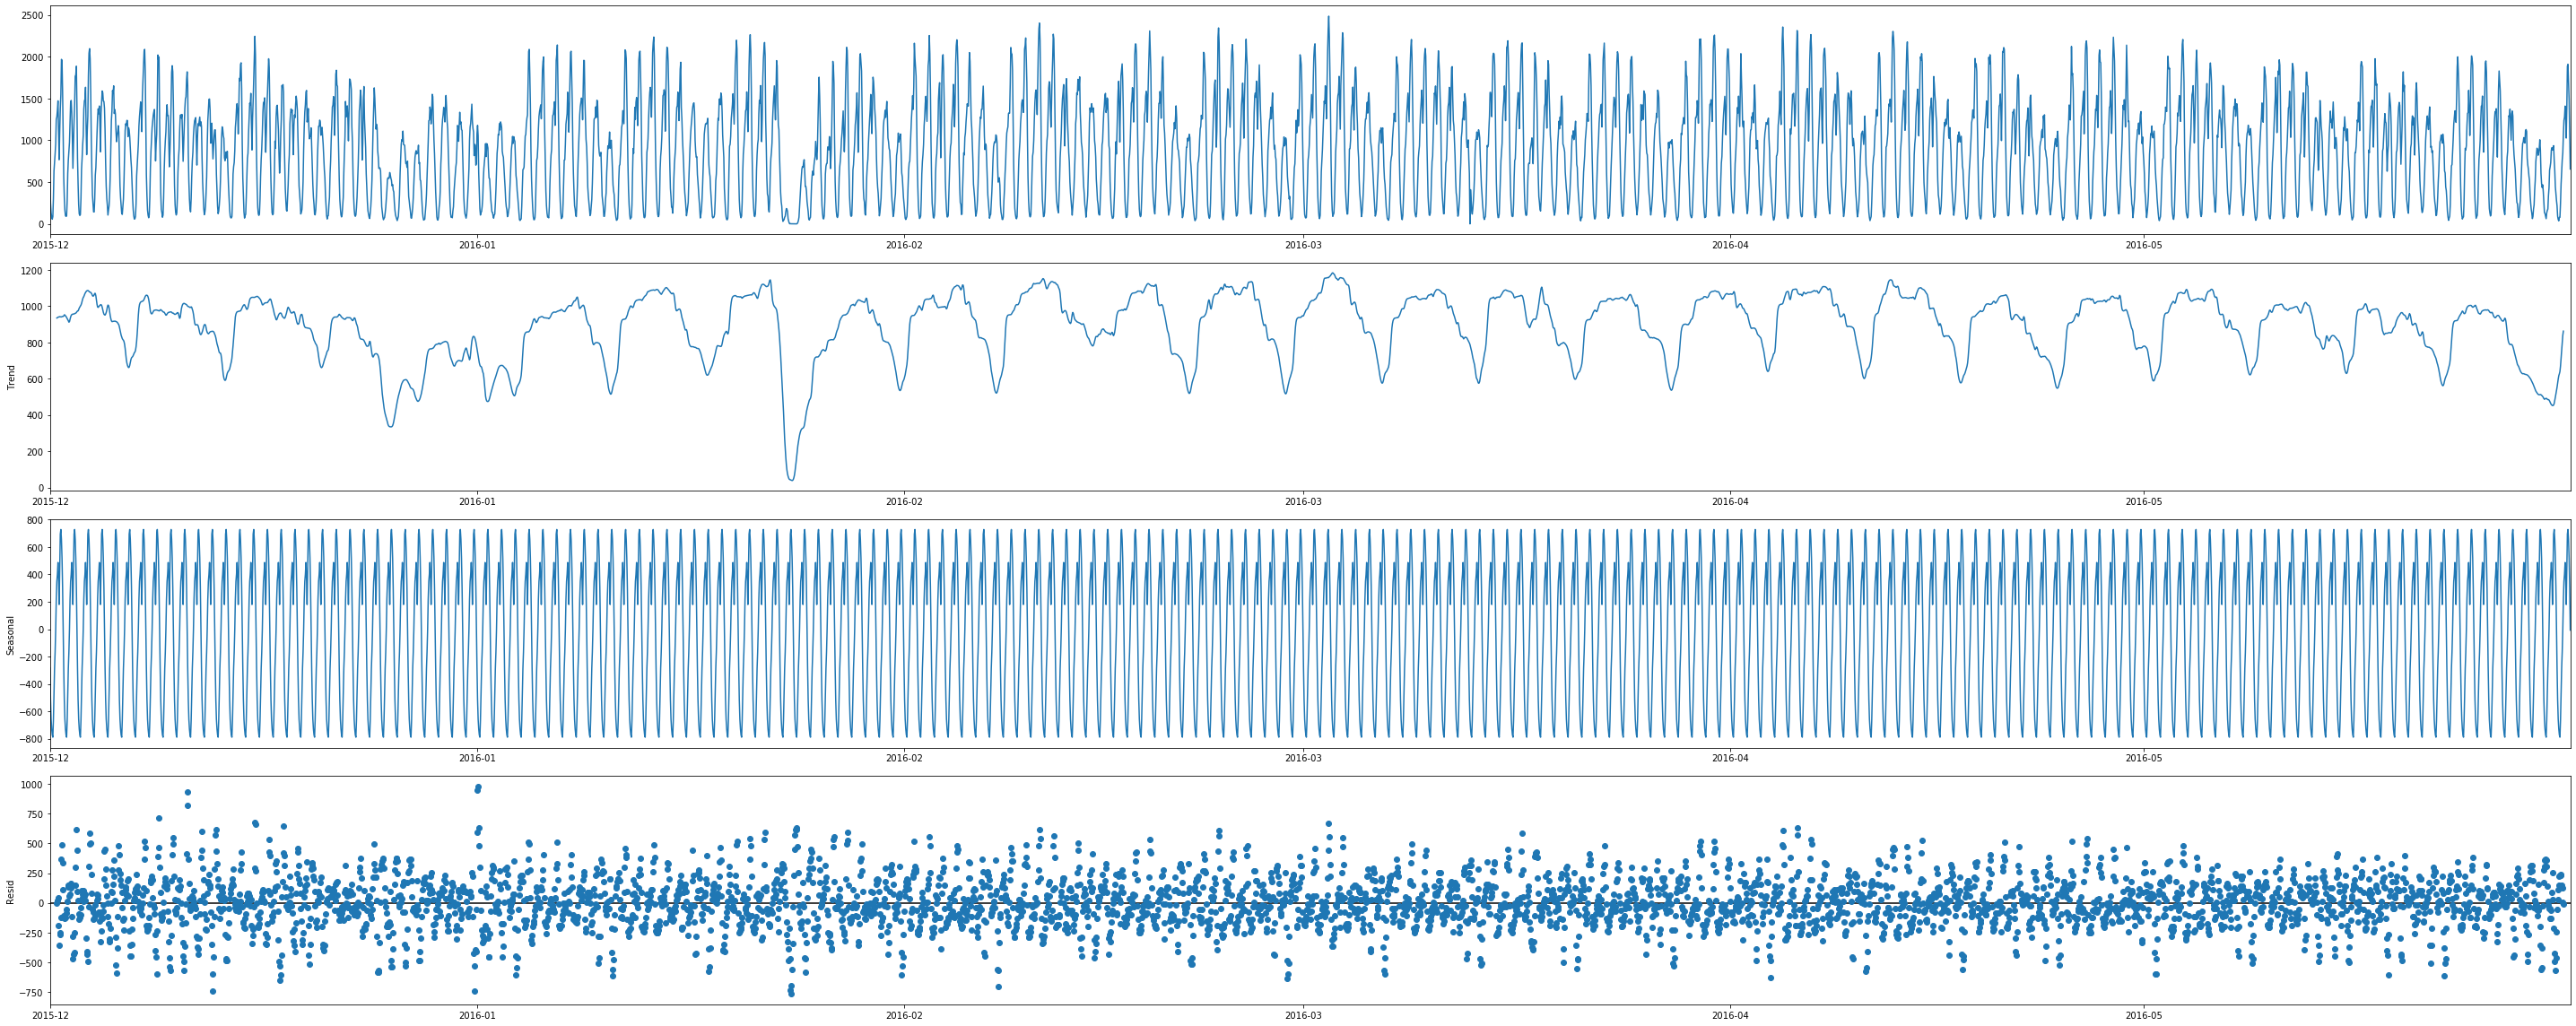

In [4]:
pylab.rcParams['figure.figsize'] = (40, 16)
res = sm.tsa.seasonal_decompose(data.iloc[-4392:].set_index('datetime')[['count']], period=24)
res.plot()
plt.show()

признаки на дату/время

In [5]:
for i in range(7):
    data['weekday_' + str(i)] = data['date'].apply(lambda x: int(x.weekday() == i))
    
data['day_of_month'] = data['datetime'].dt.day
data['hour_of_day'] = data['datetime'].dt.hour

сезонные признаки

In [6]:
# недельная сезонность
k = 7
t = np.arange(1, data.shape[0] + 1)
lag = 168
for i in range(1, k + 1):
    s = np.sin(t * 2 * np.pi * i / lag)
    c = np.cos(t * 2 * np.pi * i / lag)
    s_name = 'sin_{}_{}'.format(i, lag)
    c_name = 'cos_{}_{}'.format(i, lag)
    data[s_name] = s
    data[c_name] = c

In [9]:
# годовая сезонность
k = 7
t = np.arange(1, data.shape[0] + 1)
lag = 8766
for i in range(1, k + 1):
    s = np.sin(t * 2 * np.pi * i / lag)
    c = np.cos(t * 2 * np.pi * i / lag)
    s_name = 'sin_{}_{}'.format(i, lag)
    c_name = 'cos_{}_{}'.format(i, lag)
    data[s_name] = s
    data[c_name] = c

In [7]:
X = data.drop(['region_id', 'date', 'hour', 'datetime', 'count'], axis=1)
X['const'] = 1
y = data['count']

In [8]:
quick_reg = sm.OLS(y,X).fit()

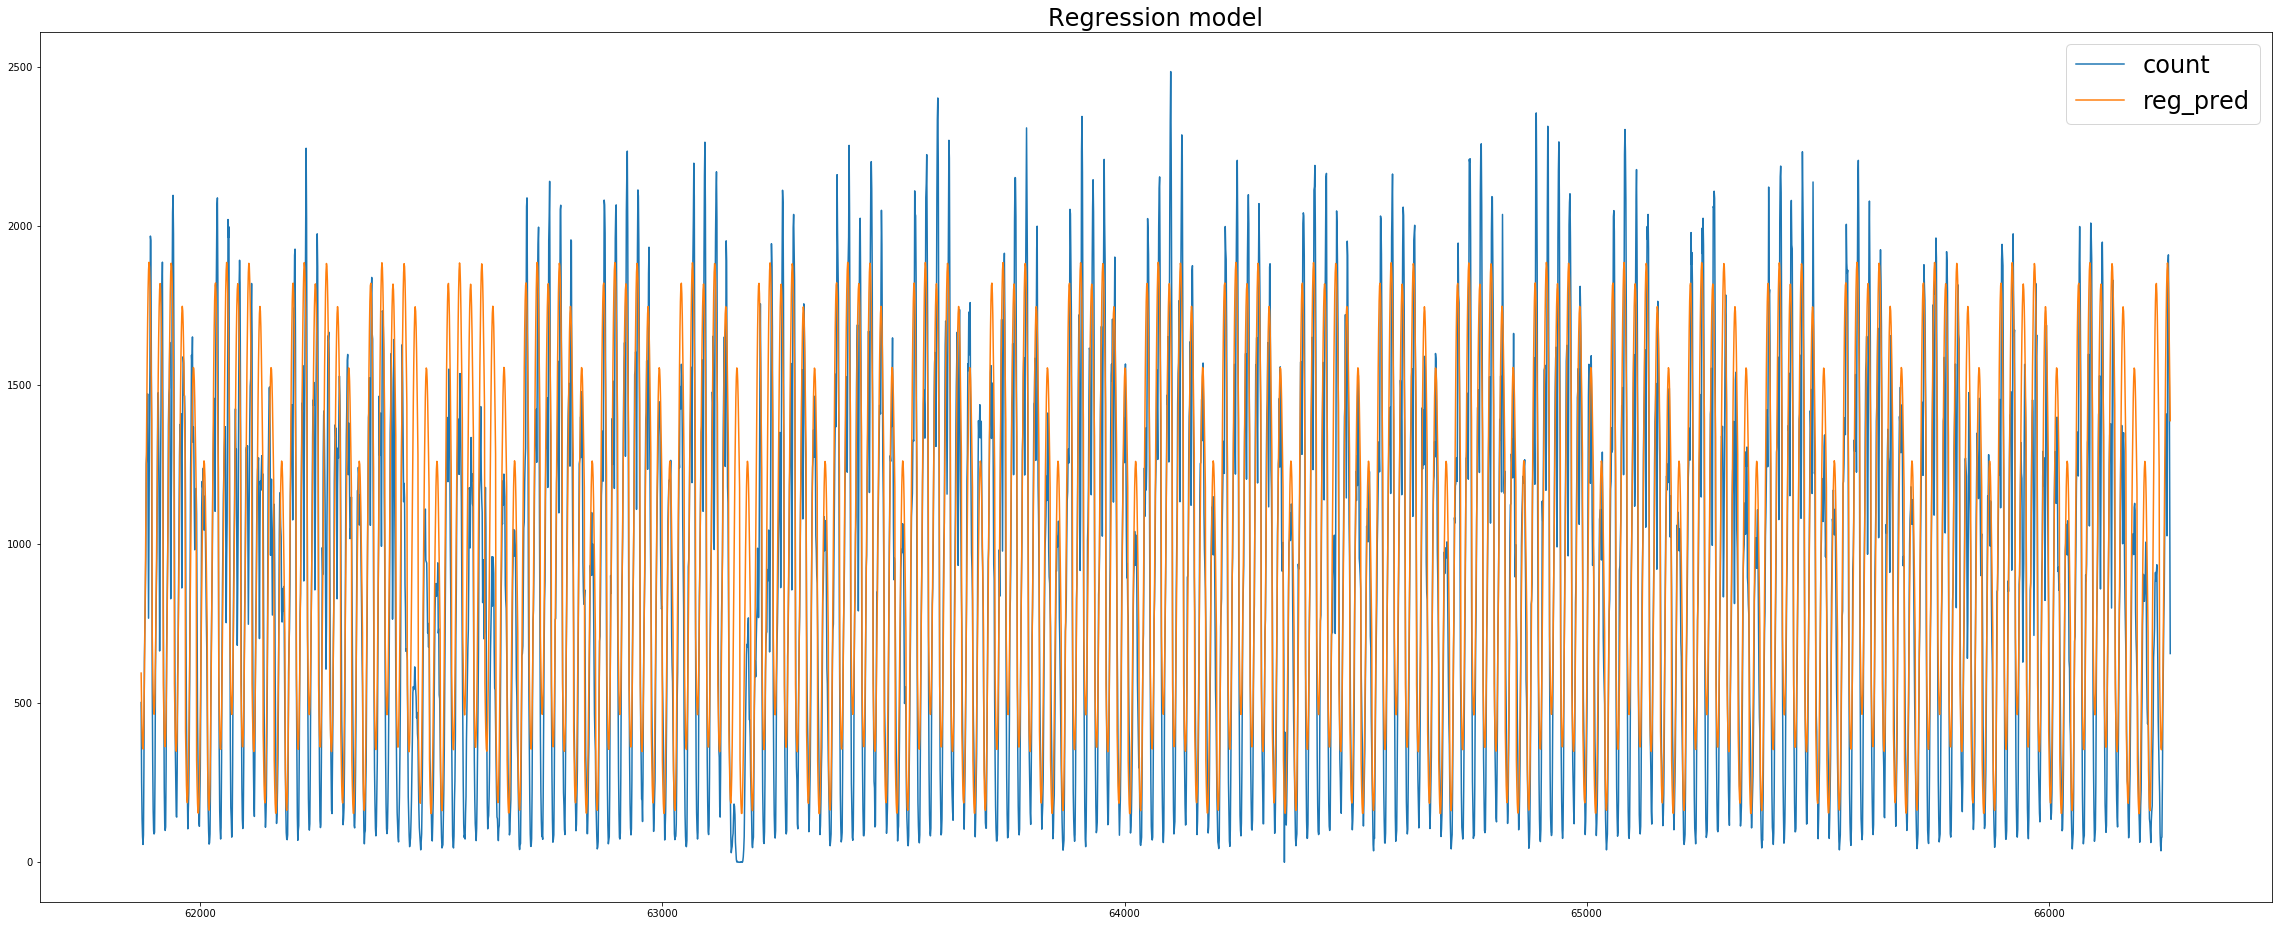

In [9]:
data['reg_pred'] = quick_reg.predict(X)
data['count'].iloc[-4392:].plot()
data['reg_pred'].iloc[-4392:].plot()
plt.title('Regression model',size=24)
plt.legend(fontsize=24)

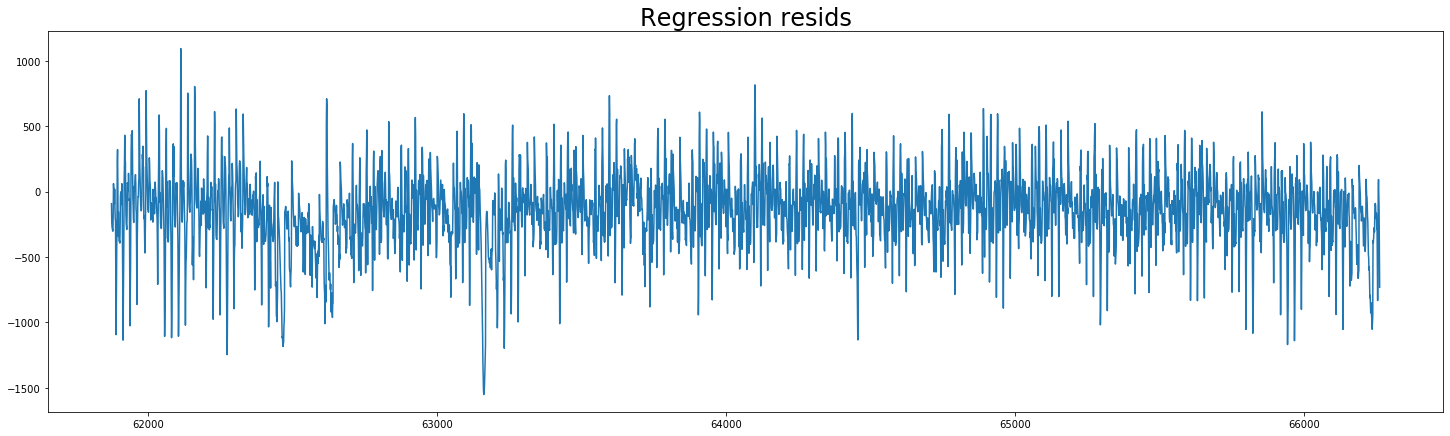

Mean error:  -5.643852187749428e-13
MSE:  165211.85977378223
MAE:  305.7069147860406


In [10]:
plt.figure(figsize=(25,7))
data['reg_resid'] = quick_reg.resid
data['reg_resid'].iloc[-4392:].plot()
plt.title('Regression resids',size=24)
plt.show()
print("Mean error: ", quick_reg.resid.mean())
print("MSE: ", (data['reg_resid'] ** 2).mean())
print("MAE: ", data['reg_resid'].abs().mean())

### Диффернцирование

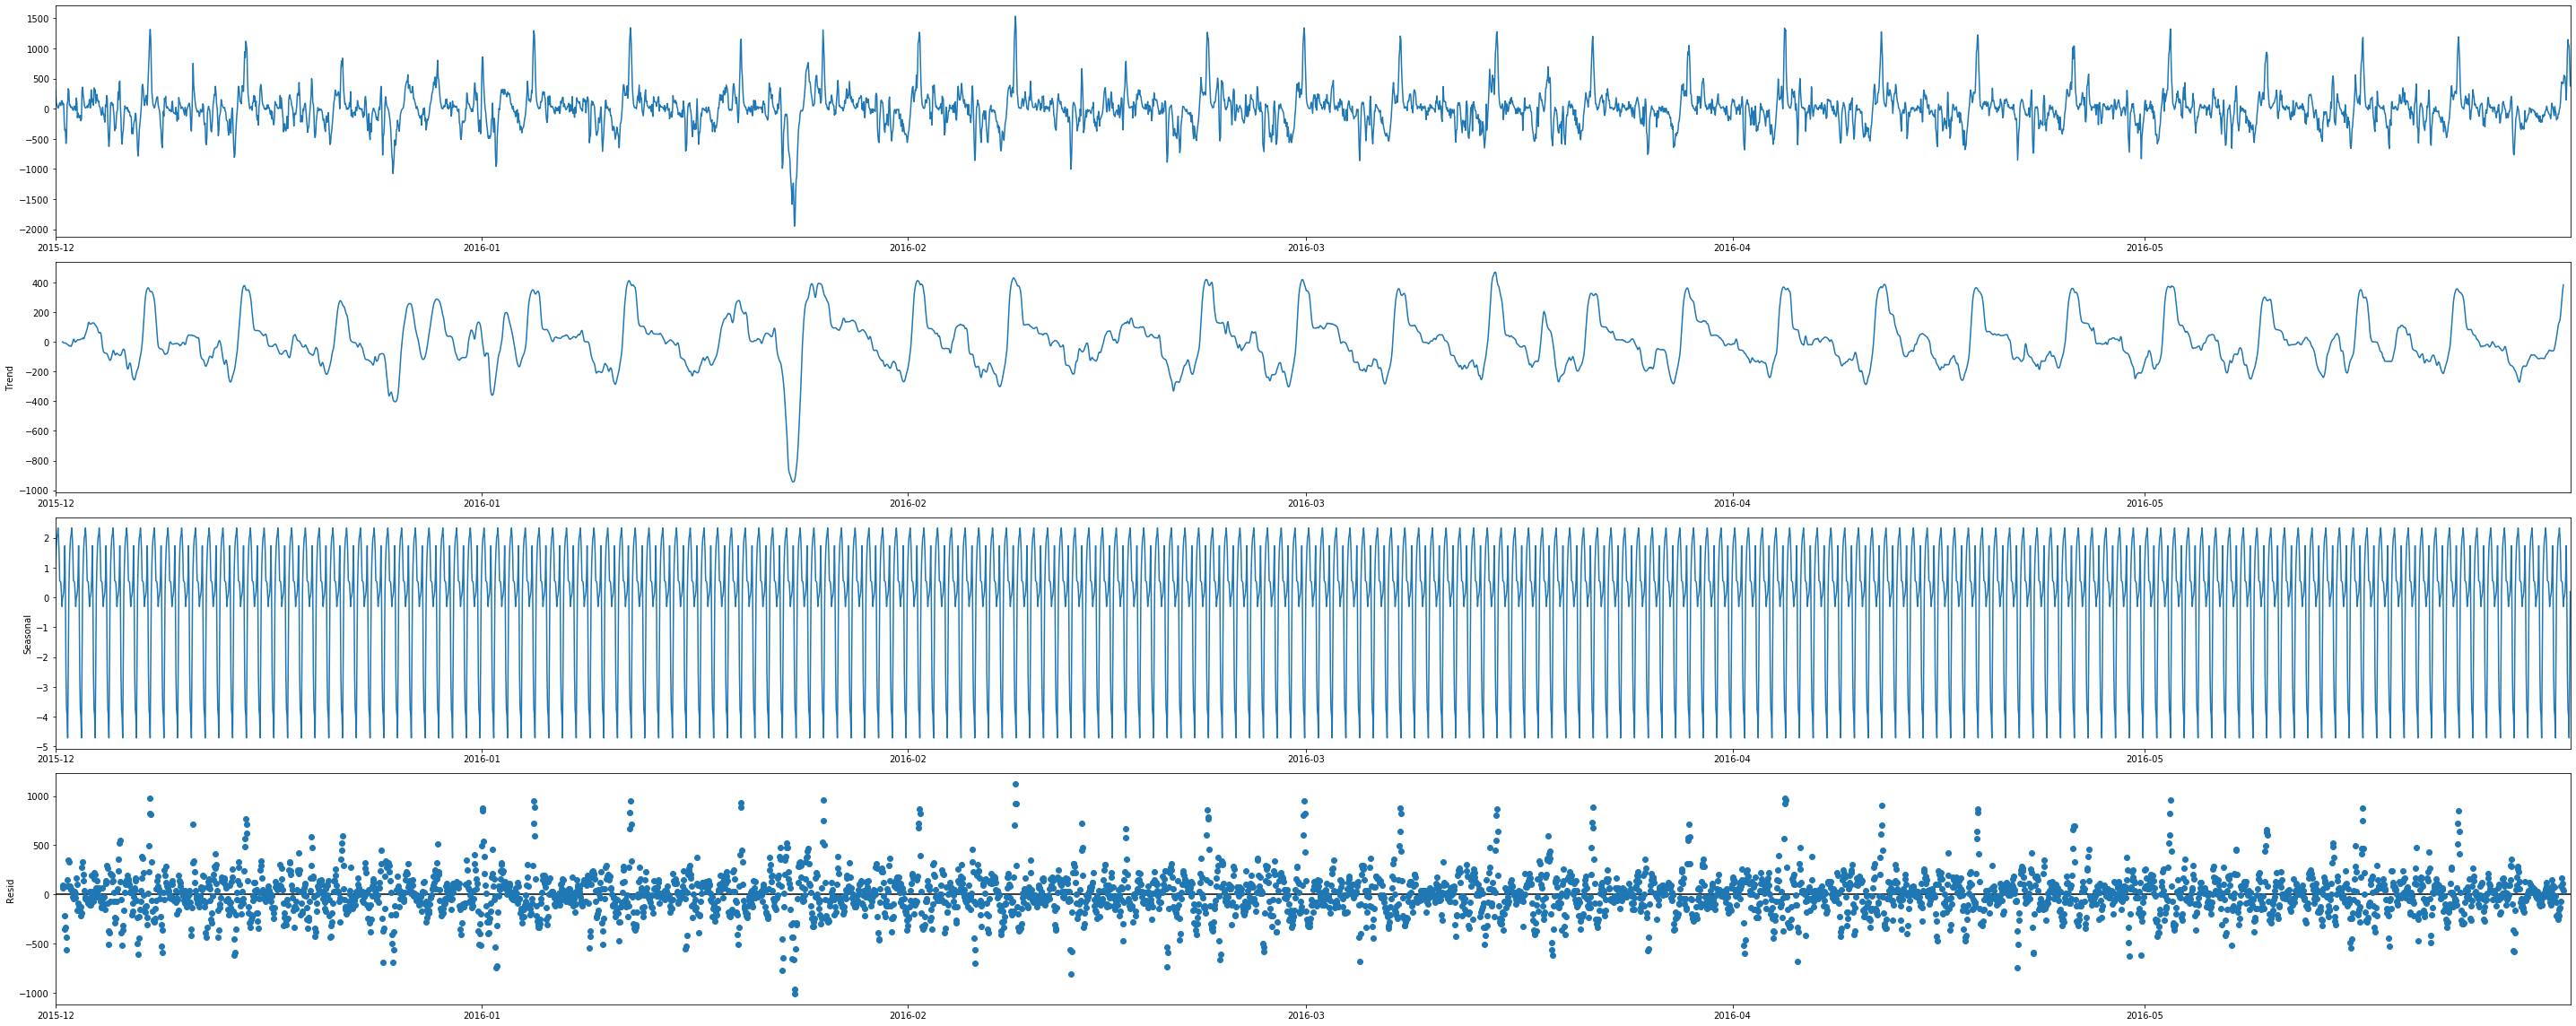

In [11]:
pylab.rcParams['figure.figsize'] = (40, 16)
data['diff_24'] = data['count'].diff(24)
sm.tsa.seasonal_decompose(data.iloc[-4392:].set_index('datetime')[['diff_24']], period=24).plot()
plt.show()

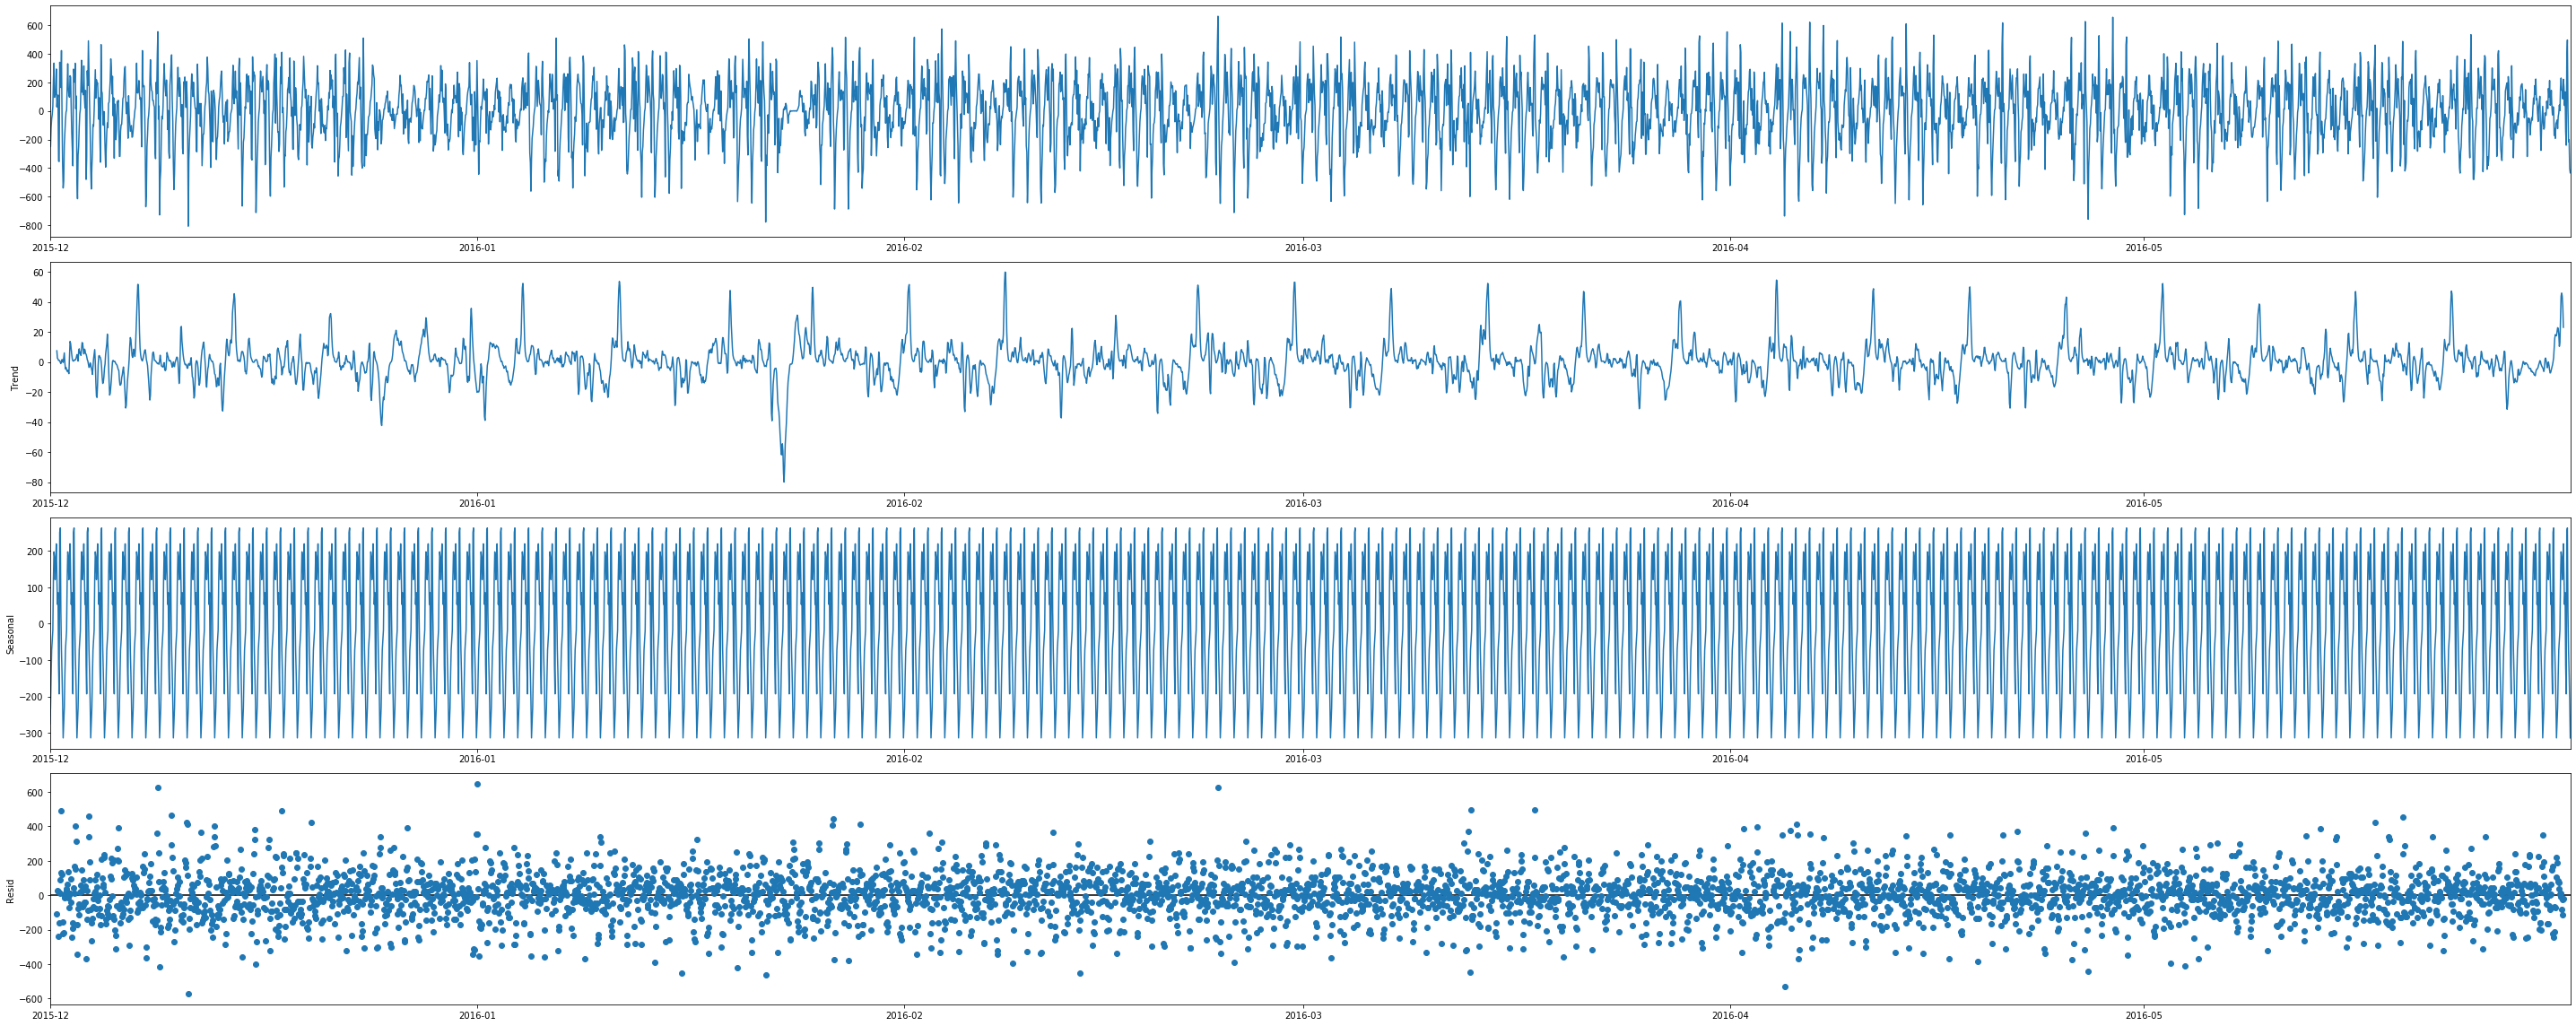

In [12]:
pylab.rcParams['figure.figsize'] = (40, 16)
data['diff_1'] = data['count'].diff(1)
sm.tsa.seasonal_decompose(data.iloc[-4392:].set_index('datetime')[['diff_1']], period=24).plot()
plt.show()

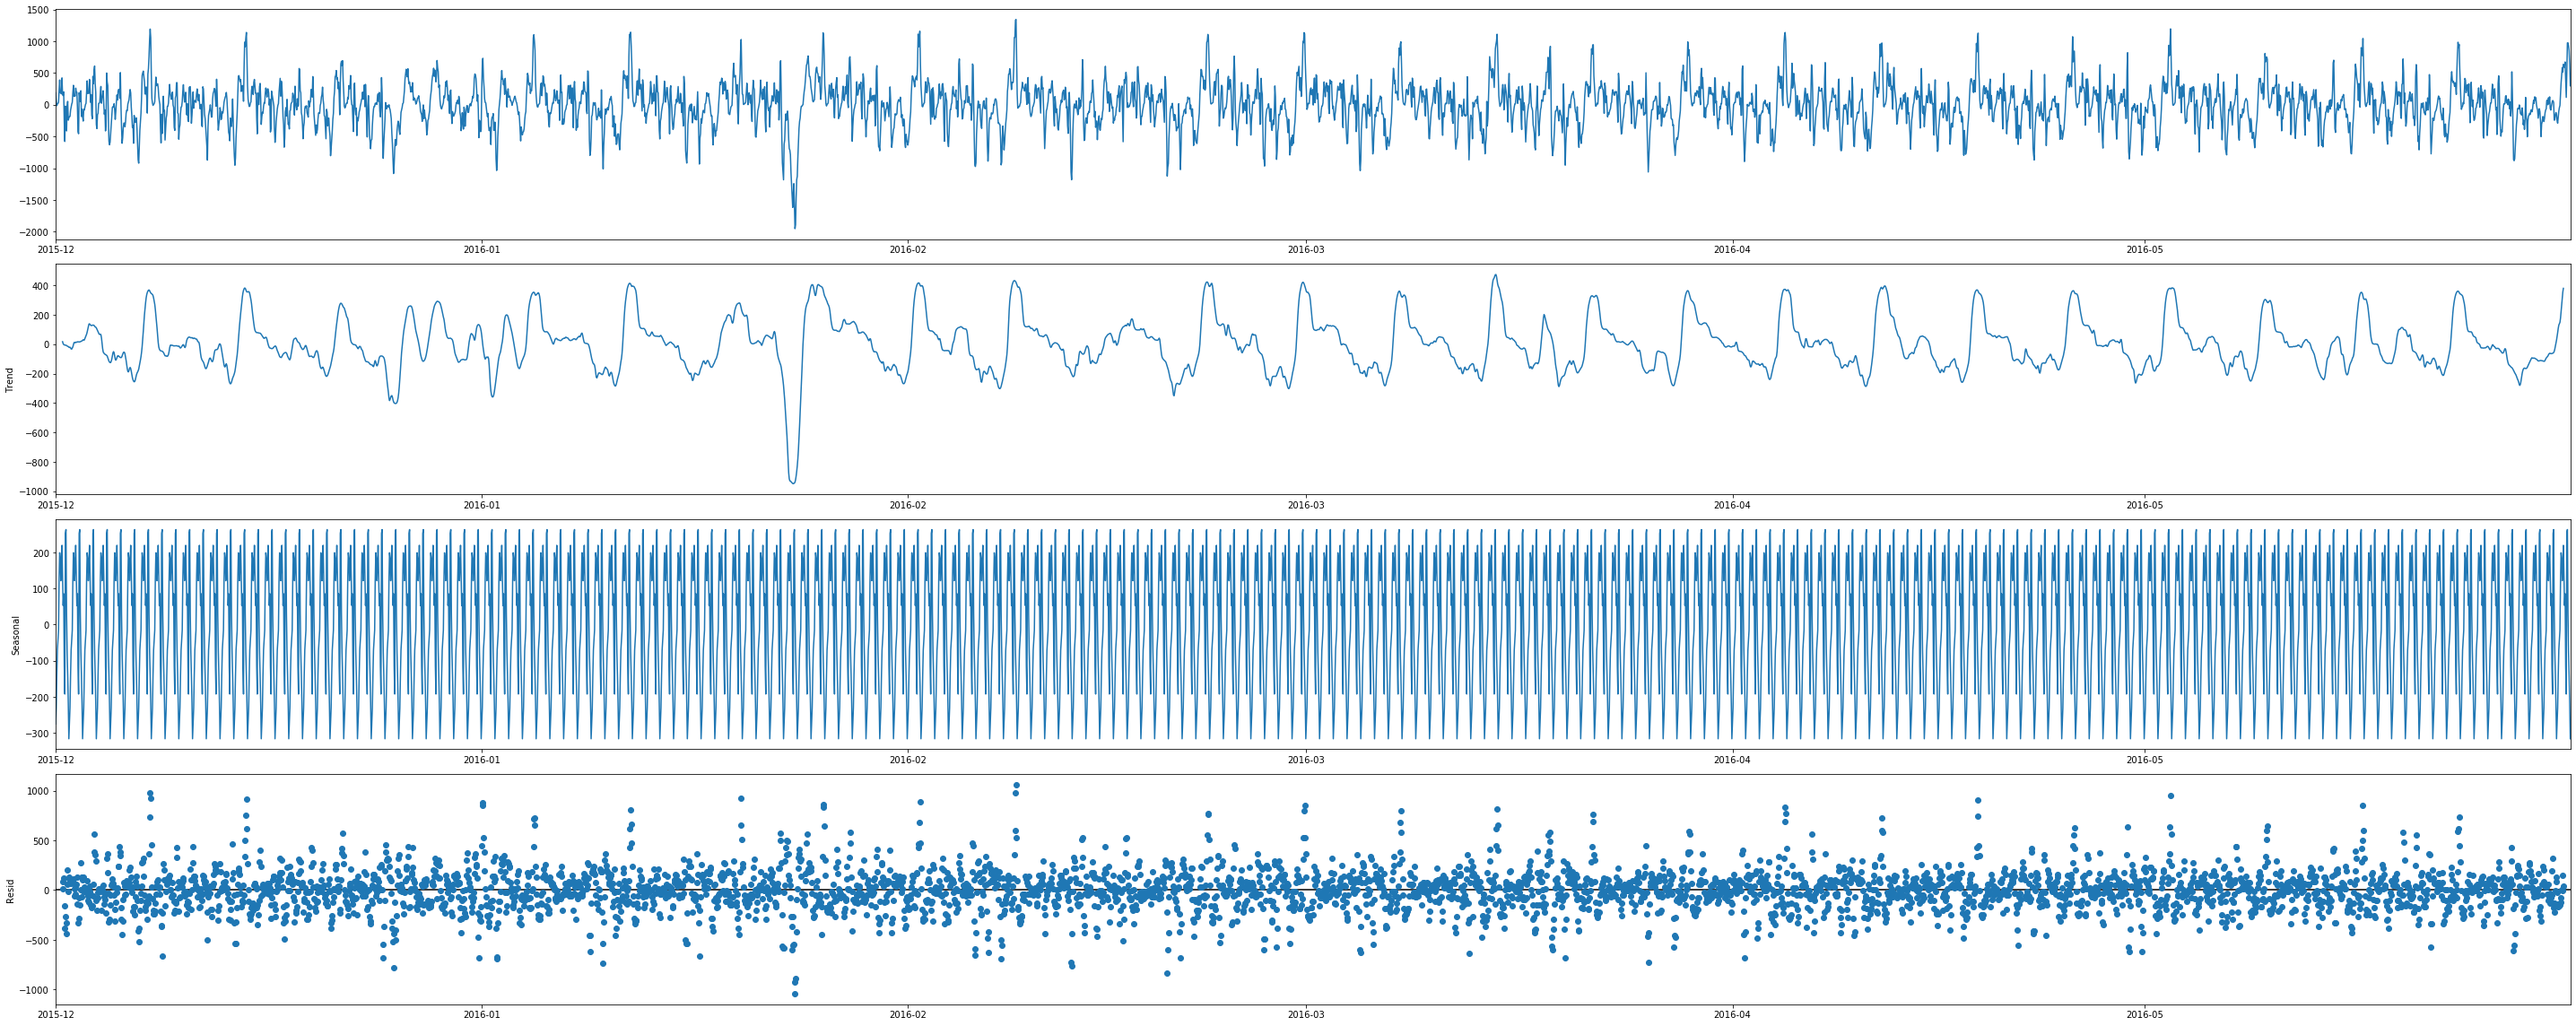

In [13]:
pylab.rcParams['figure.figsize'] = (40, 16)
data['diff_25'] = data['count'].diff(25)
sm.tsa.seasonal_decompose(data.iloc[-4392:].set_index('datetime')[['diff_25']], period=24).plot()
plt.show()

### SARIMA

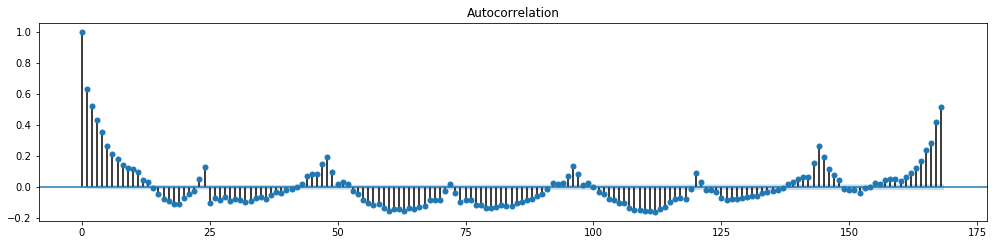

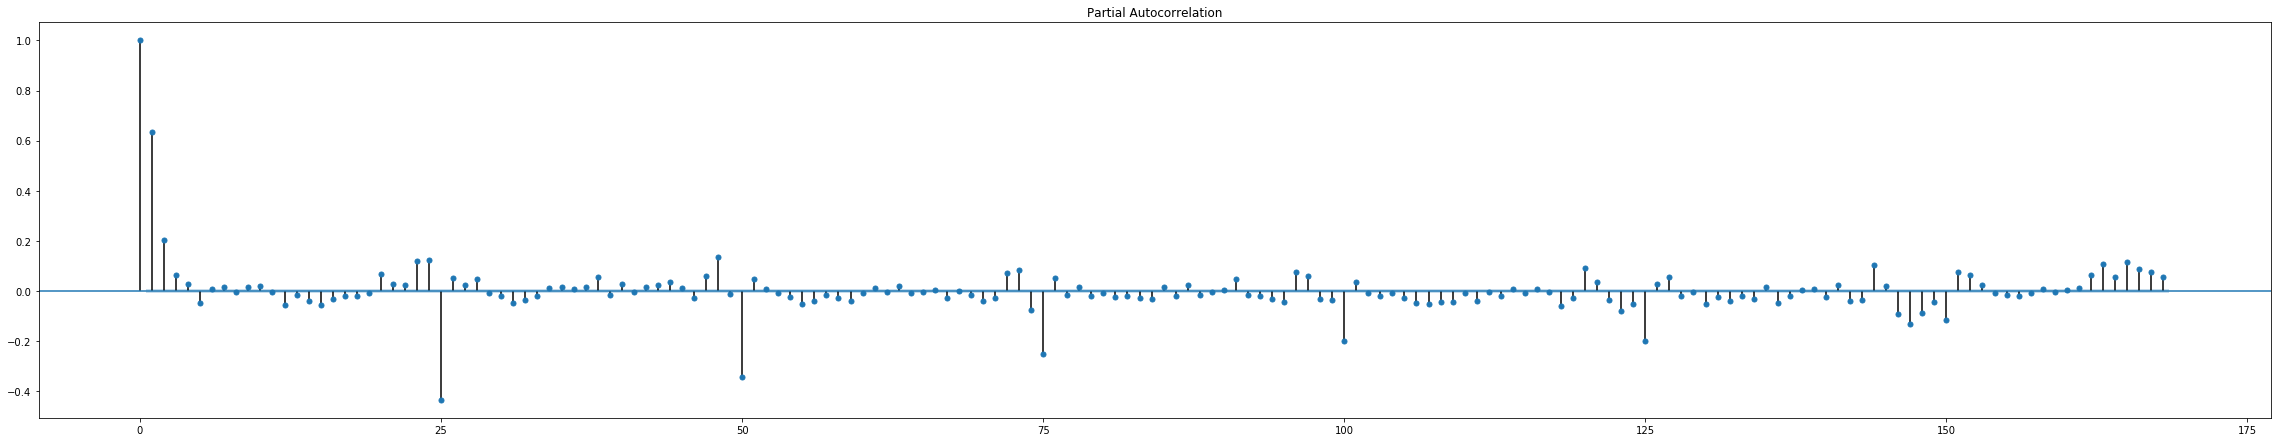

In [14]:
plt.figure(figsize=(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['diff_25'].dropna().values.squeeze(), lags=168, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['diff_25'].dropna().values.squeeze(), lags=168, ax=ax)
plt.show()

In [15]:
p = 7
q = 7
P = 2 
Q = 2
d = 1 
D = 1

In [16]:
ps = range(0, p)
qs = range(0, q)
Ps = range(0, P)
Qs = range(0, Q)

all_params = list(product(ps, qs, Ps, Qs))
len(all_params)

196

In [17]:
data = data.iloc[-4392:]

In [18]:
#%%time
import time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

i = 0
wall_time = 0
for param in all_params:
    start = time.time()
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['diff_25'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),
                                        initialization='approximate_diffuse').fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
    end = time.time()
    print('Набор {} Время: {}'.format(i+1, end-start))
    i += 1
    wall_time += end - start
    
print(wall_time)
warnings.filterwarnings('default')

Набор 1 Время: 0.5392708778381348
Набор 2 Время: 19.439805269241333
Набор 3 Время: 2.979888916015625
Набор 4 Время: 30.138383150100708
Набор 5 Время: 1.4162969589233398
Набор 6 Время: 48.23127484321594
Набор 7 Время: 8.058459758758545
Набор 8 Время: 33.61159300804138
Набор 9 Время: 1.8414509296417236
Набор 10 Время: 52.08571791648865
Набор 11 Время: 9.376035928726196
Набор 12 Время: 48.74743986129761
Набор 13 Время: 1.7059428691864014
Набор 14 Время: 52.47371292114258
Набор 15 Время: 11.955597162246704
Набор 16 Время: 79.684072971344
Набор 17 Время: 1.953460931777954
Набор 18 Время: 67.83088684082031
Набор 19 Время: 15.162719011306763
Набор 20 Время: 77.98593211174011
Набор 21 Время: 2.152797222137451
Набор 22 Время: 96.17190718650818
Набор 23 Время: 16.4723858833313
Набор 24 Время: 120.93661618232727
Набор 25 Время: 3.318347930908203
Набор 26 Время: 93.4268741607666
Набор 27 Время: 18.83784294128418
Набор 28 Время: 97.61933898925781
Набор 29 Время: 0.5285742282867432
Набор 30 Время: 1

In [19]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

parameters           aic
131  (4, 4, 1, 1)  55782.299164
51   (1, 5, 1, 1)  55900.414836
183  (6, 3, 1, 1)  55901.188929
179  (6, 2, 1, 1)  55901.197560
119  (4, 1, 1, 1)  55921.700072

### Итоговая модель

In [20]:
#создаем модель прогнозирования остатков
model=sm.tsa.statespace.SARIMAX(data['reg_resid'], order=(4, d,4), 
                                        seasonal_order=(1, D, 1, 24),
                                initialization='approximate_diffuse').fit(disp=-1)

/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


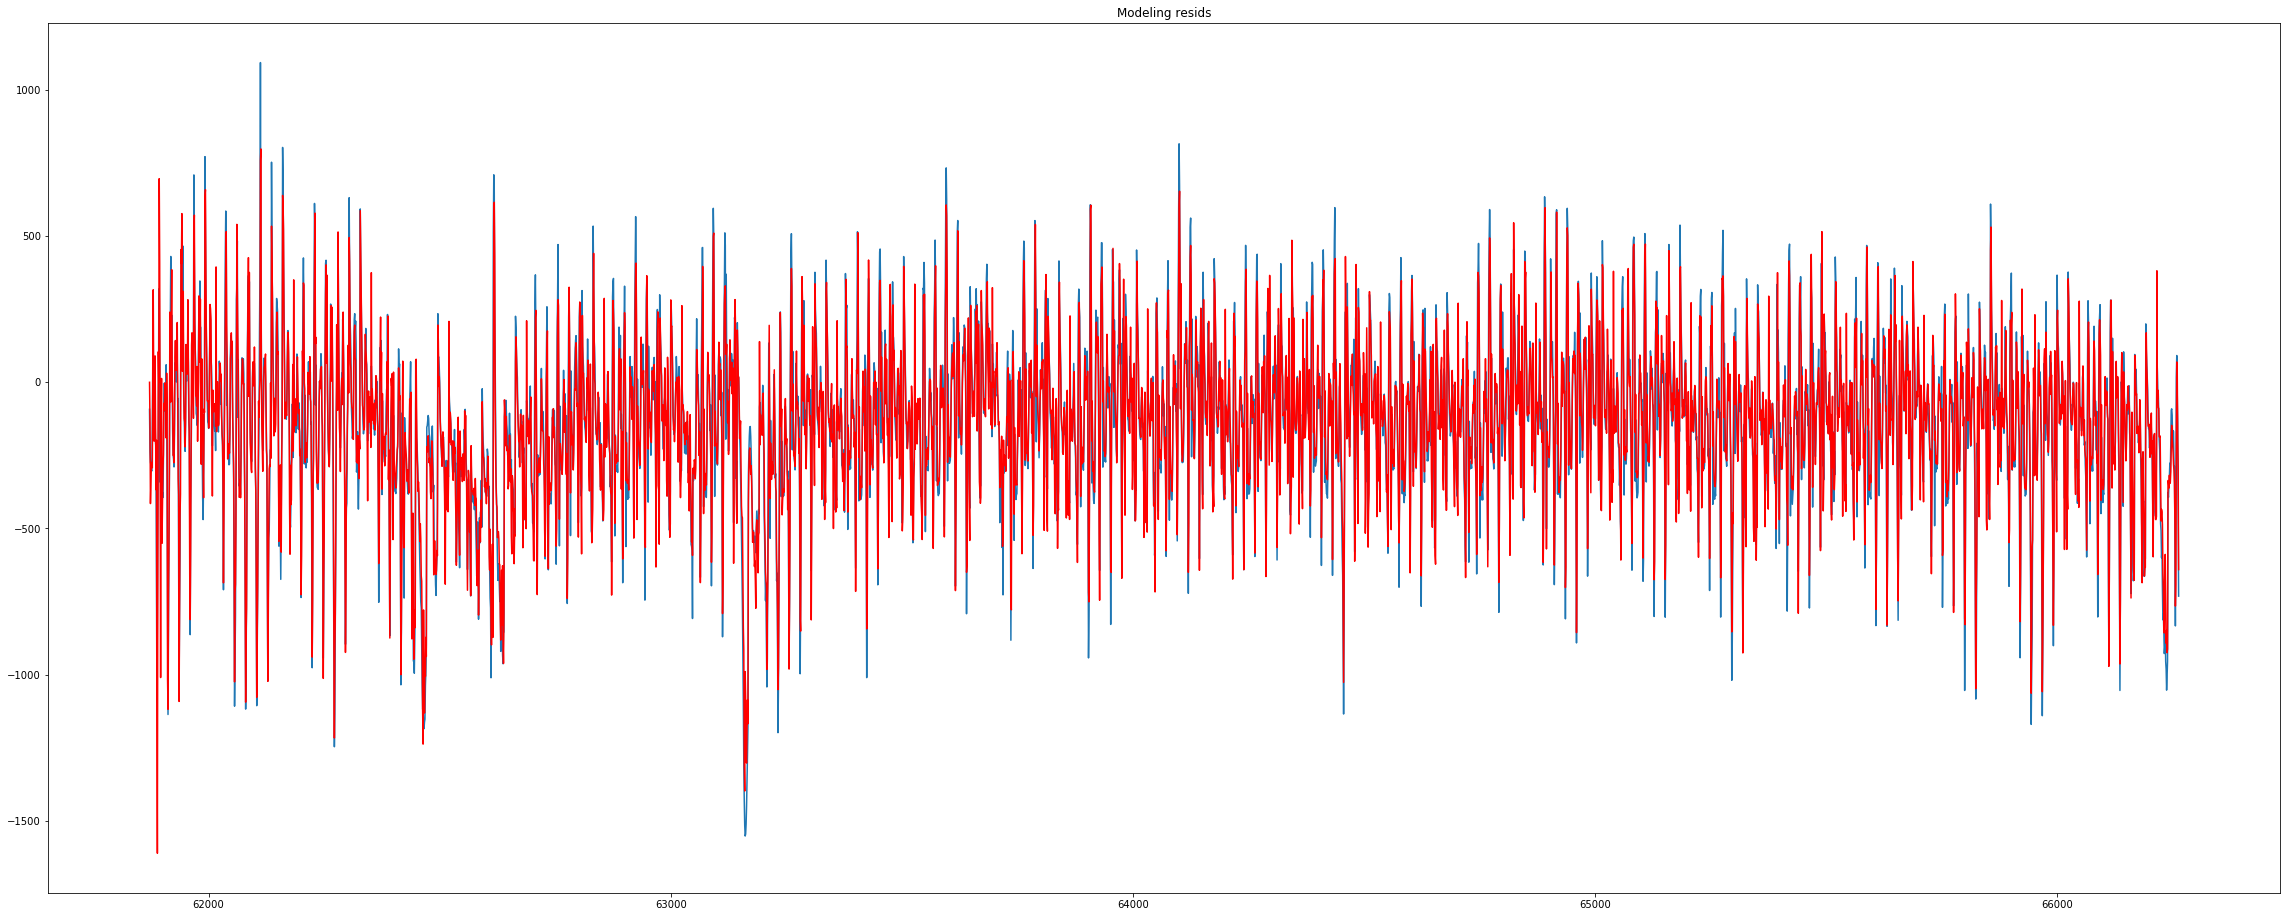

In [21]:
data['reg_resid'].plot()
model.fittedvalues.plot(color='r')
plt.title('Modeling resids')
pylab.show()

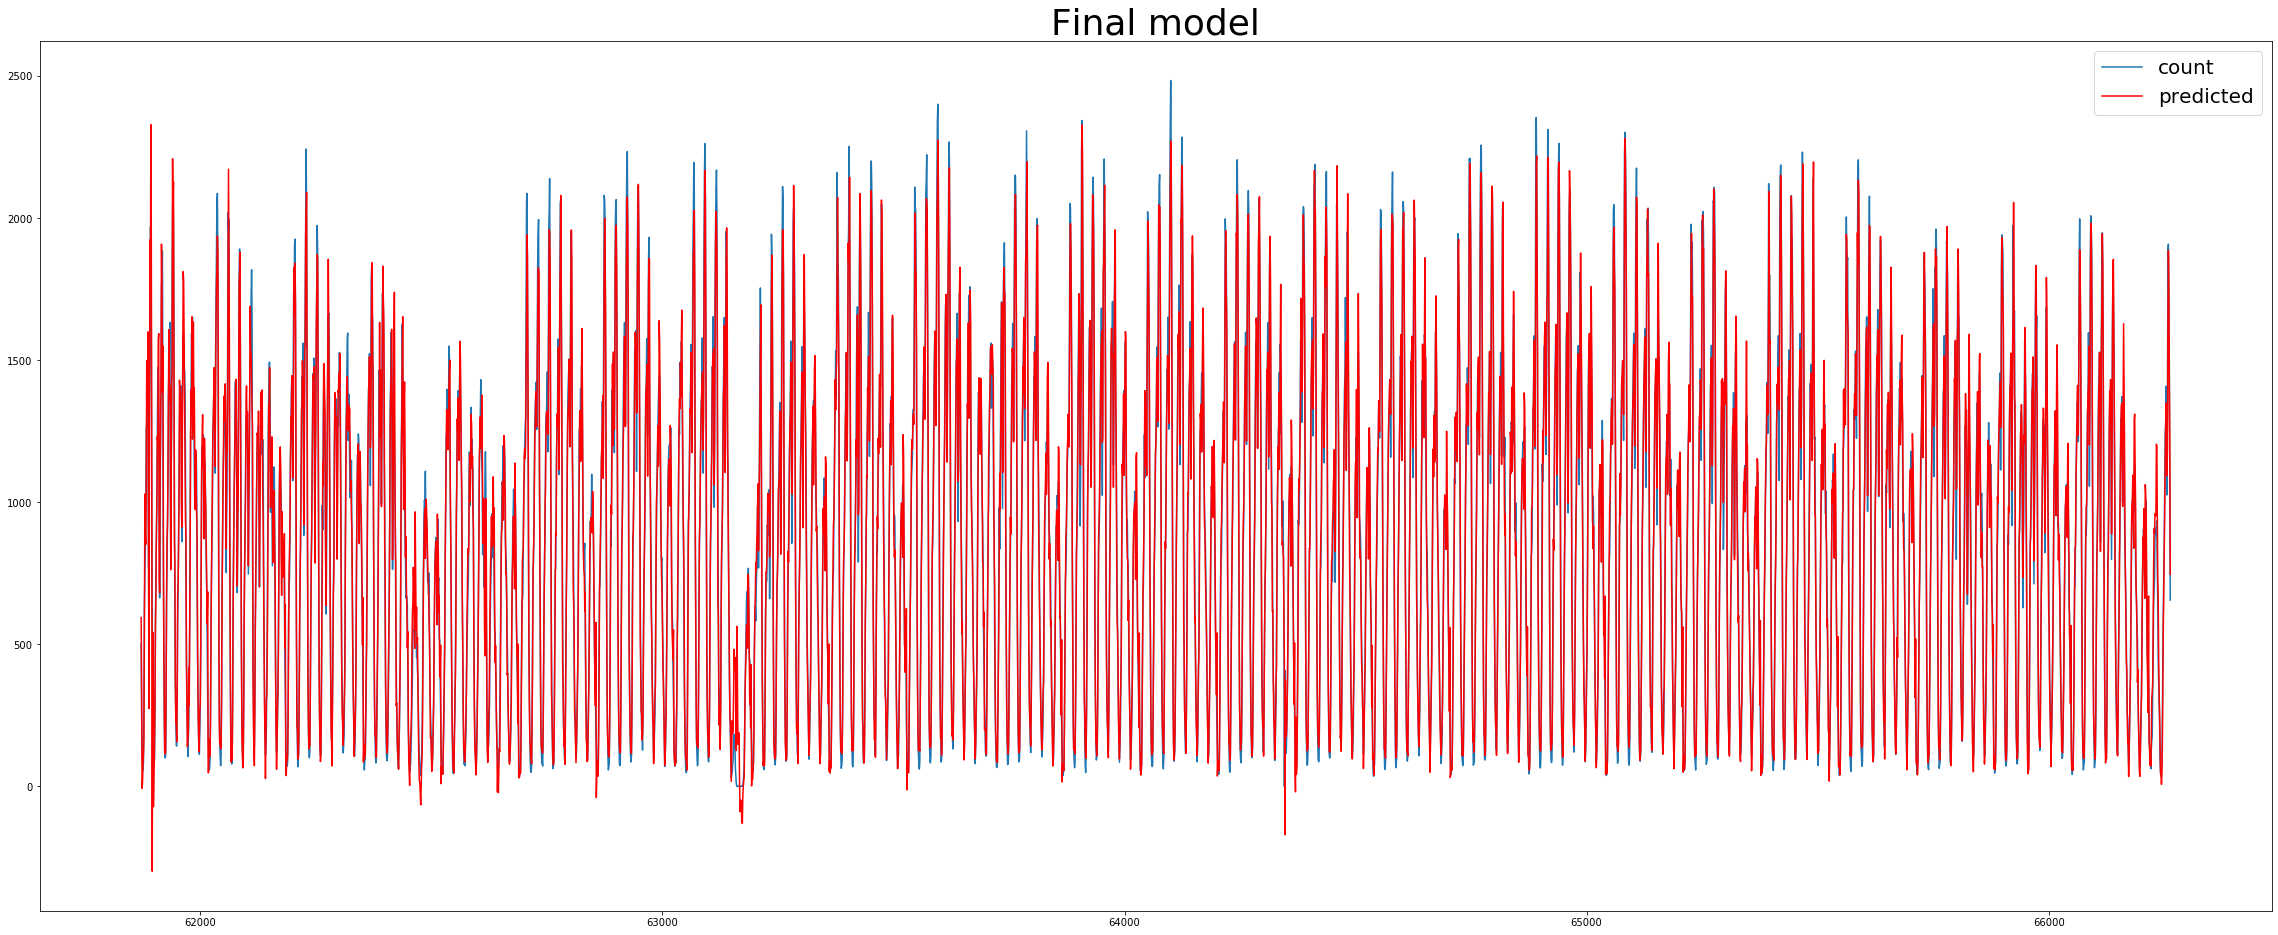

In [23]:
data['count'].plot()
predictions = quick_reg.predict(X) + model.fittedvalues
data['predicted'] = predictions
data['predicted'].plot(color='r')
plt.title('Final model',size=36)
plt.legend(fontsize=20)
plt.show()

In [25]:
data['resid'] = data['count'] - data['predicted']
print('Mean error: ', data['resid'].mean())
print('MSE: ', (data['resid']**2).mean())
print('MAE: ', data['resid'].abs().mean())

Mean error:  0.7061064593012574
MSE:  11884.309377711608
MAE:  77.85407631596436


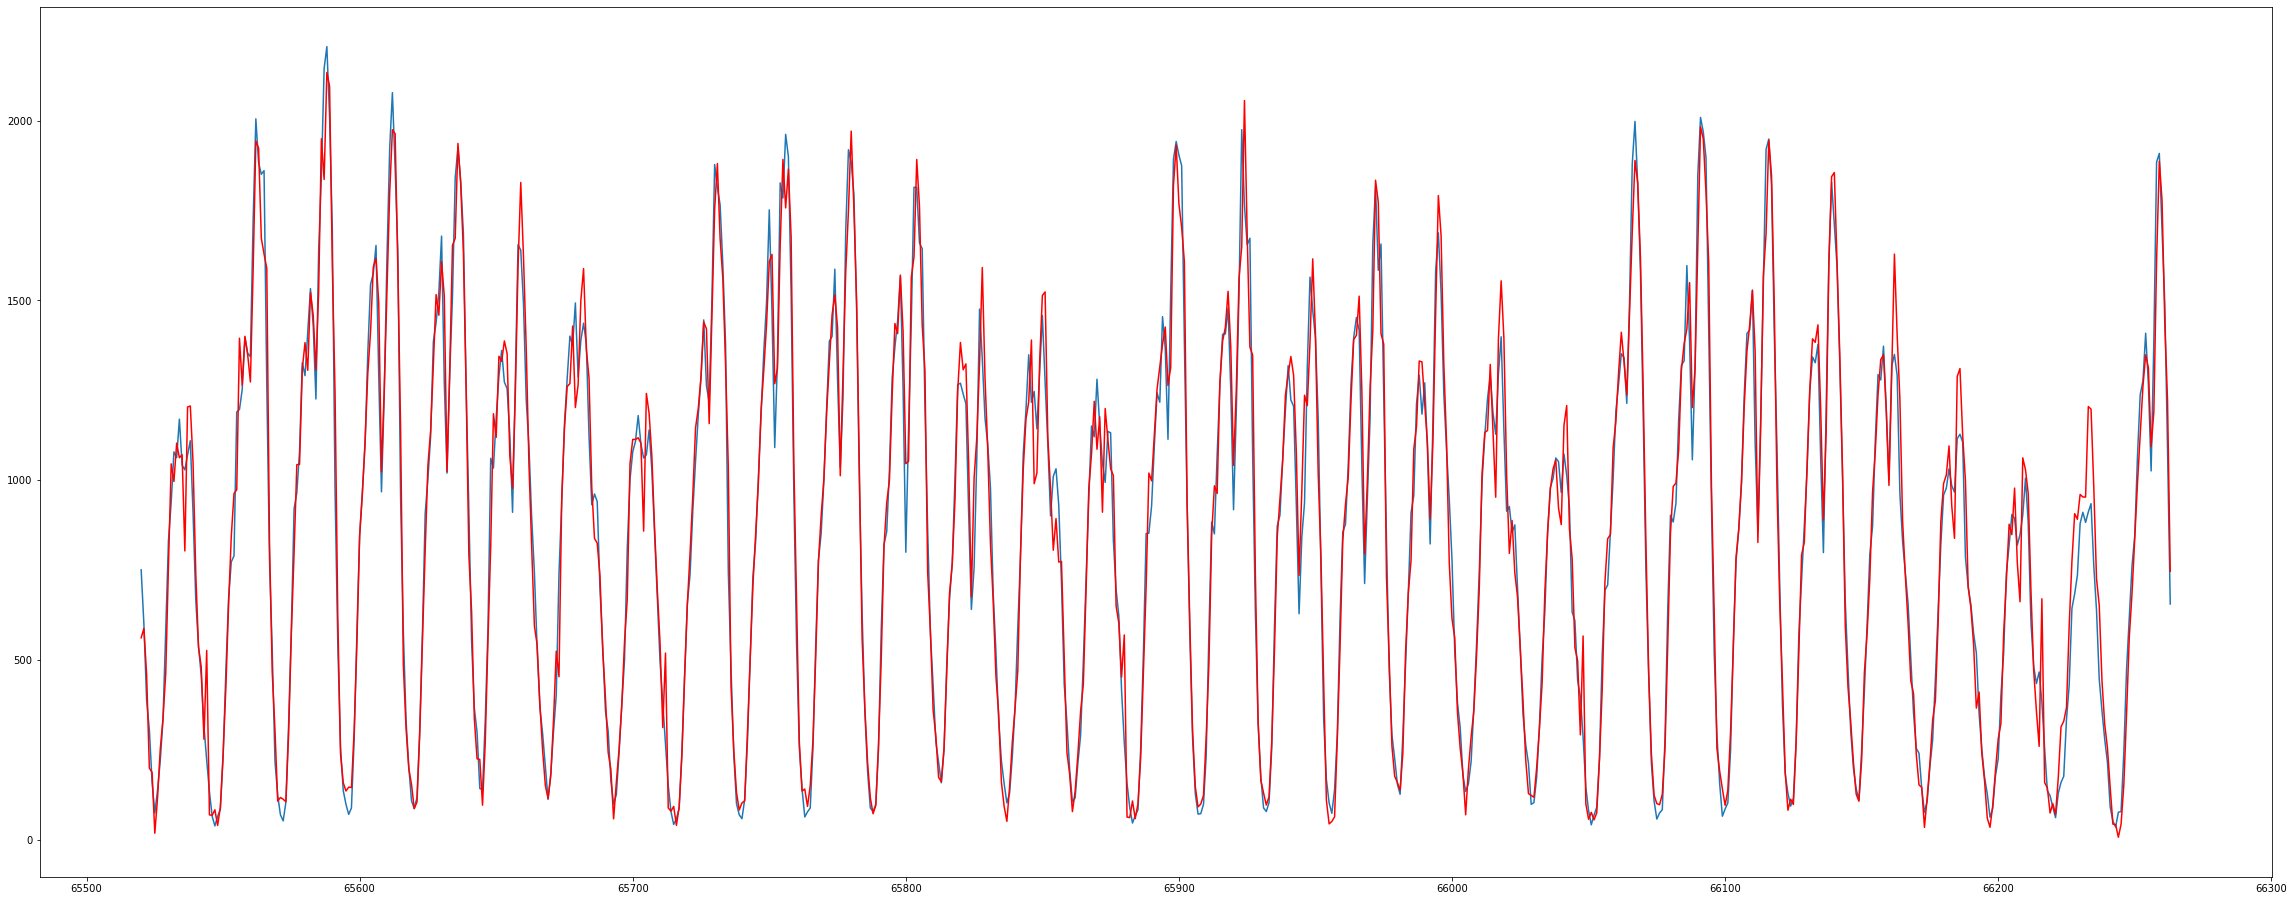

In [29]:
data.iloc[-744:]['count'].plot()
data.iloc[-744:]['predicted'].plot(color='r')


Нормально она приближает, и внутри суток, и внутри недели, и внутри меясца сезонности учитываются. Для формальности глянем на распределение остатков итоговой модели.

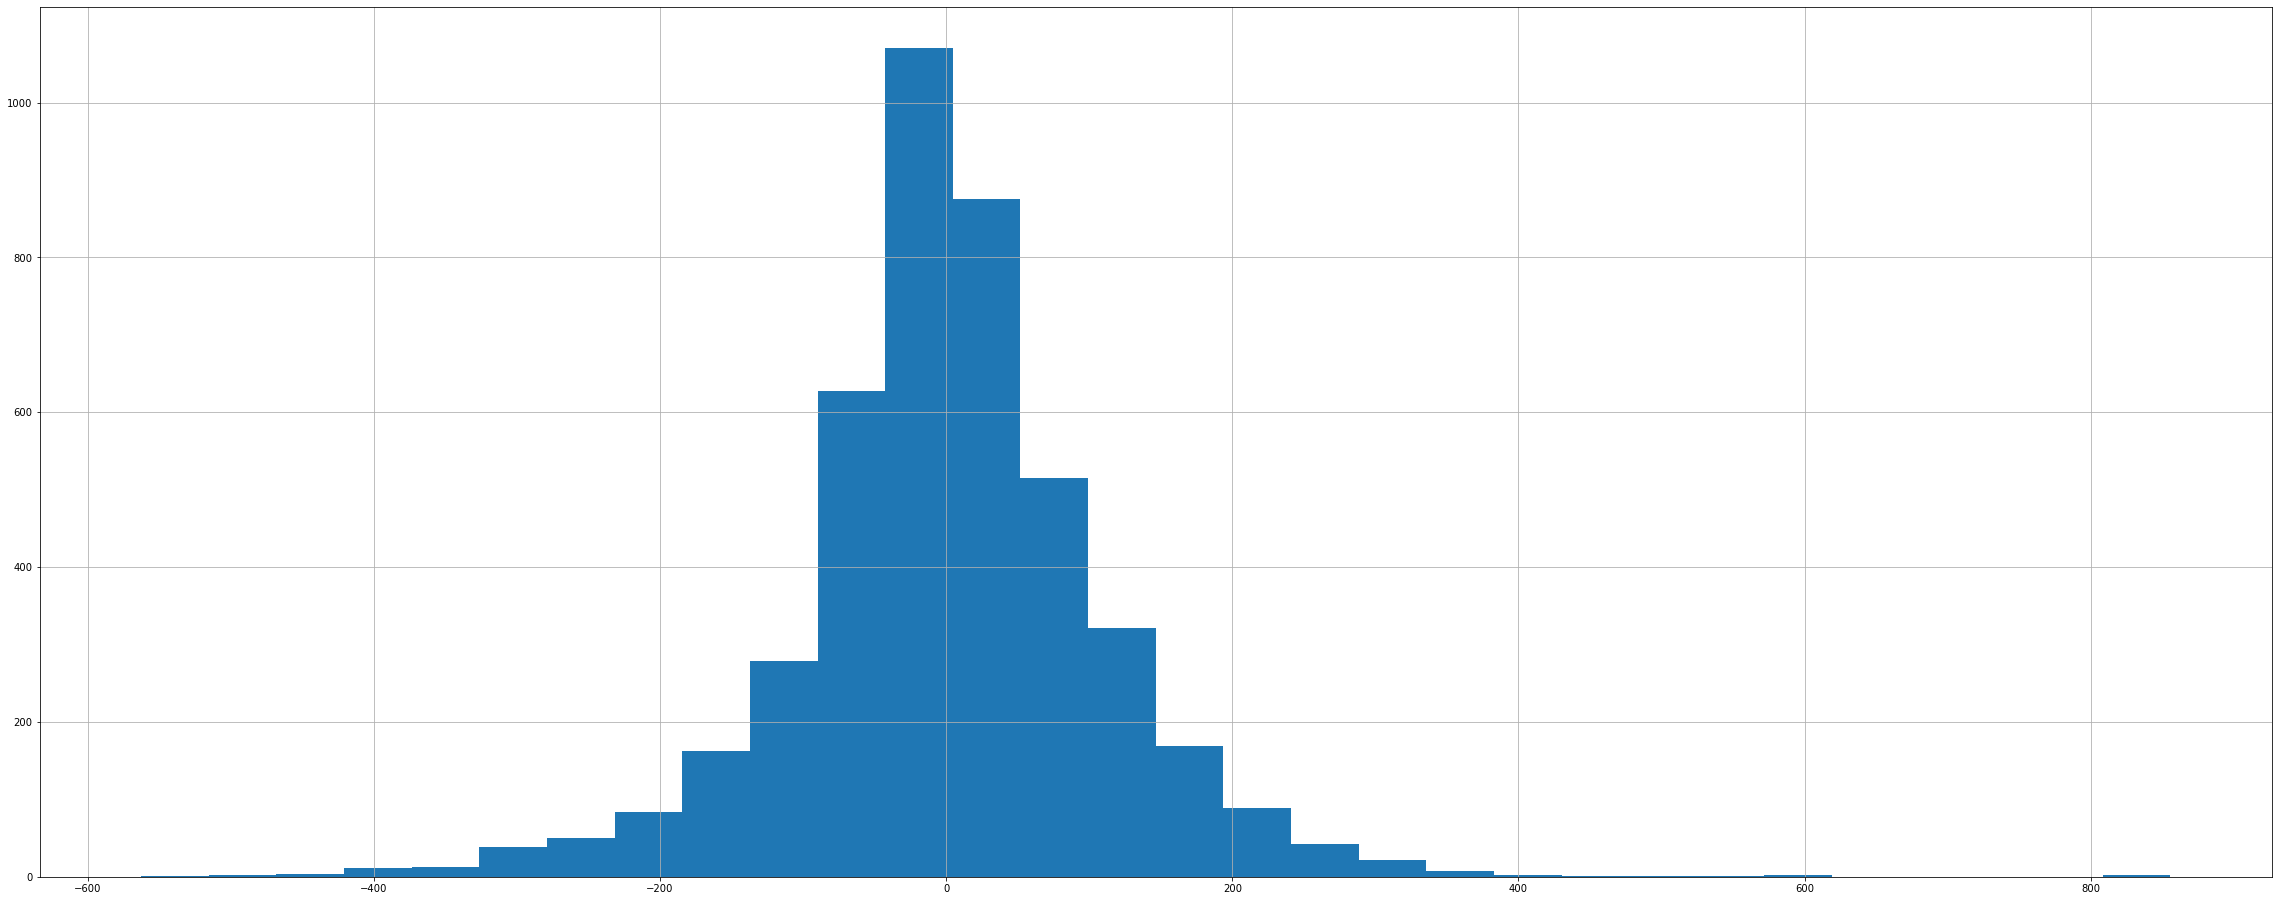

In [30]:
data['resid'].hist(bins=30)

Вполне себе нормально они распределны, значит, можно сказать, что остатки несмещены и нормальны, так что их можно назвать шумом. Посему смело заявляем, что наша модель работает корректно.

## Выводы по модели и ее качеству

Думаю, я выбрал очень удачную модель - регрессию по многим признакам, отчасти учитывающим сезонности. Благодаря этому моделирование остатков при помощи SARIMA получилось вполне эффективным, и качество итоговой модели меня устраивает. Повысить его можно, исправив недочет в подборе параметров, но мне на это не хватит терпения.

P.S. По мне SARIMA - очень посредственный метод. Параметры определяются перебором (даже не научным тыком), начальные приблежения на глаз и вообще какого-то надежного обоснования у модели нет. А в моем случае она строилась "от балды" и благодаря удаче.